## 🌀 𝐏𝐫𝐞𝐬𝐬𝐢𝐧𝐠 𝐈𝐧𝐭𝐞𝐧𝐬𝐢𝐭𝐲: 𝐴𝑛 𝐼𝑛𝑡𝑢𝑖𝑡𝑖𝑣𝑒 𝑀𝑒𝑎𝑠𝑢𝑟𝑒 𝑓𝑜𝑟 𝑃𝑟𝑒𝑠𝑠𝑖𝑛𝑔 𝑖𝑛 𝐹𝑜𝑜𝑡𝑏𝑎𝑙𝑙

Within this notebook we demonstrate how to compute [𝐏𝐫𝐞𝐬𝐬𝐢𝐧𝐠 𝐈𝐧𝐭𝐞𝐧𝐬𝐢𝐭𝐲](https://unravelsports.github.io/2024/12/12/pressing-intensity.html) ([ArXiv PDF](https://arxiv.org/abs/2501.04712)) for a single sequence of play from freely available positional tracking data of 1. FC Köln vs. FC Bayern München (May 27th 2023), using the new `unravel.soccer.PressingIntensity`, [Kloppy](https://kloppy.pysport.org/) and [Polars](https://pola.rs/).

We will create an `.mp4` video (as shown below, on the left) of this 35-second segment of play using [mplsoccer](https://mplsoccer.readthedocs.io/en/latest/), [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/). 

🗒️ You can also use this to compute **Pressing Intensity** for a whole game in under a minute!

🗒️ The match video blew is for illustrative purposes only, you'll need to source and sync your own match footage

![1. FC Köln vs. FC Bayern München (May 27th 2023)](assets/gif/preview.gif)

In [ ]:
from unravel.utils import display

from os.path import join

display.show(
    video_path=[
        join("assets", "video", "KOL v BAY (Pressing Intensity).mp4"),
        join("assets", "video", "KOL v BAY.mp4"),
    ]
)

-------

### 0. Installation

First install `unravelsports` if you haven't done so already!

In [2]:
# %pip install unravelsports --quiet

You might need to `pip install ffmpeg mplsoccer matplotlib seaborn` for this to work.

-----

### 1. Loading Open Tracking Dataset

To start we load a single game of DFL (Sportec) open tracking data ([Bassek, M. et al. (2024)](https://www.nature.com/articles/s41597-025-04505-y)). 

You can choose any of the following games:

```python
matches = {
    'J03WMX': "1. FC Köln vs. FC Bayern München",
    'J03WN1': "VfL Bochum 1848 vs. Bayer 04 Leverkusen",
    'J03WPY': "Fortuna Düsseldorf vs. 1. FC Nürnberg",
    'J03WOH': "Fortuna Düsseldorf vs. SSV Jahn Regensburg",
    'J03WQQ': "Fortuna Düsseldorf vs. FC St. Pauli",
    'J03WOY': "Fortuna Düsseldorf vs. F.C. Hansa Rostock",
    'J03WR9': "Fortuna Düsseldorf vs. 1. FC Kaiserslautern"
}
```

**Kloppy Parameters**

We load the data using kloppy and setting `limit=5000`. We do this because our moment happens early in the game and therefor we don't need to load the whole dataset.

**Coordinate System**

We load the data with the "secondspectrum" coordinate system to ensure that $X \in \left[ -\frac{L_{\text{pitch}}}{2}, \frac{L_{\text{pitch}}}{2} \right]$ and $Y \in \left[ -\frac{W_{\text{pitch}}}{2}, \frac{W_{\text{pitch}}}{2} \right]$

In [3]:
from kloppy import sportec

coordinates = "secondspectrum"

kloppy_dataset = sportec.load_open_tracking_data(
    match_id="J03WMX", coordinates=coordinates, limit=5000
)

------

### 2. Data Preparation

We use the `KloppyPolarsDataset` to convert the regular kloppy `TrackingDataset` into a Polars dataframe with some additional stuff. 

We set `orient_ball_owning=False`, this is useful to not overwrite the playing directions. Leaving this as the default `True` would rotate the pitch every time the ball changes possession. This would render the resulting video unwatchable.

💡 For example we can call `dataset.settings` to get an overview of the settings that relate to the newly created `KloppyPolarsDataset` object.

❌ Creating a video of a full match might not be the greatest idea :)

In [4]:
from unravel.soccer import KloppyPolarsDataset

dataset = KloppyPolarsDataset(kloppy_dataset=kloppy_dataset, orient_ball_owning=False)

------

### 3. Pressing Intensity Out of the Box

Now, we're going to use the `PressingIntensity` model (see [the 𝐏𝐫𝐞𝐬𝐬𝐢𝐧𝐠 𝐈𝐧𝐭𝐞𝐧𝐬𝐢𝐭𝐲 blog](https://unravelsports.github.io/2024/12/12/pressing-intensity.html) and/or [Bekkers (2015)](https://arxiv.org/abs/2501.04712) for more information) in combination with the newly created `dataset` to fit this model on.

#### > Match segment

As an example we select a match segment from Köln vs. Bayern with high pressing intensity as shown in the video at the top. This segment runs from approximately 1:52 to 2:32 in the first half.

💡 Feel free to run it on the whole game, by removing `start_time`, `end_time` and `period_id`. It should take between 15-60 seconds to compute the whole match. Please note that you'll have to reload the kloppy and polars datasets too without the `limit=5000`.

#### > PressingIntensity Parameters

- **method** determines how we assign to rows and columns in the **Pressing Intensity** matrix. 
  - "teams" will set one team as the rows, and the other team as the columns. (Matrix is 11x11)
  - "full" will set both teams as the rows and as the columns. (Matrix is 22x22)
- **ball_method** determines who we handle pressure in relation to the ball within the **Pressing Intensity** matrix.
  - "max" will assign the maximum value on the ball carrying player of either a player applying pressure on them, or on the ball.
  - "include" will simply include the ball object as it's own row / column in the matrix, resulting in a 11x12 or 23x23 matrix. 
  - "exclude" will not consider the ball.
- **orient** when we set **method="teams"** this allows you to choose which axis will be the home or the away team . 
  - "home_away" will set the home team as the rows and away team as columns
  - "away_home" will set the away team as the rows and home team as columns
  - "ball_owning" will set the ball owning team as the rows and pressing team as the columns
  - "pressing" will set the pressing team as the rows and ball owning team as the columns
- **orient** when we set **method="full"** this will order the rows and columns accordingly with the indicated team showing first.

#### > PressingIntensity Output

`model.output` is a Polars dataframe with one row per frame and a NxN matrix for time_to_intercept, probability_to_intercept and the corresponding object ids for the columns and rows


In [5]:
from unravel.soccer import PressingIntensity

import polars as pl

model = PressingIntensity(dataset=dataset)
model.fit(
    start_time=pl.duration(minutes=1, seconds=53),
    end_time=pl.duration(minutes=2, seconds=32),
    period_id=1,
    method="teams",
    ball_method="max",
    orient="home_away",
    speed_threshold=2.0,
)
model.output.head()

game_id,period_id,frame_id,timestamp,time_to_intercept,probability_to_intercept,columns,rows
str,i64,i64,duration[μs],list[list[f64]],list[list[f64]],list[str],list[str]
"""DFL-MAT-J03WMX""",1,12872,1m 54s 880ms,"[[2.390701, 2.861643, … 3.90449], [2.898738, 4.564472, … 2.922833], … [2.813985, 4.03852, … 3.4157]]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], … [0.0, 0.0, … 0.0]]","[""DFL-OBJ-0000IA"", ""DFL-OBJ-0002AU"", … ""DFL-OBJ-J01B8N""]","[""DFL-OBJ-00012X"", ""DFL-OBJ-000270"", … ""DFL-OBJ-J01D1W""]"
"""DFL-MAT-J03WMX""",1,12873,1m 54s 920ms,"[[2.232504, 2.696582, … 3.951205], [2.941554, 4.503709, … 2.966431], … [2.736845, 3.856013, … 3.459606]]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], … [0.0, 0.0, … 0.0]]","[""DFL-OBJ-0000IA"", ""DFL-OBJ-0002AU"", … ""DFL-OBJ-J01B8N""]","[""DFL-OBJ-00012X"", ""DFL-OBJ-000270"", … ""DFL-OBJ-J01D1W""]"
"""DFL-MAT-J03WMX""",1,12874,1m 54s 960ms,"[[2.13599, 2.557744, … 3.988354], [2.996597, 4.454919, … 2.972684], … [2.766442, 3.697494, … 3.498005]]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], … [0.0, 0.0, … 0.0]]","[""DFL-OBJ-0000IA"", ""DFL-OBJ-0002AU"", … ""DFL-OBJ-J01B8N""]","[""DFL-OBJ-00012X"", ""DFL-OBJ-000270"", … ""DFL-OBJ-J01D1W""]"
"""DFL-MAT-J03WMX""",1,12875,1m 55s,"[[2.065953, 2.413484, … 4.042976], [3.042859, 4.403997, … 3.015308], … [2.727374, 3.538569, … 3.547081]]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], … [0.0, 0.0, … 0.0]]","[""DFL-OBJ-0000IA"", ""DFL-OBJ-0002AU"", … ""DFL-OBJ-J01B8N""]","[""DFL-OBJ-00012X"", ""DFL-OBJ-000270"", … ""DFL-OBJ-J01D1W""]"
"""DFL-MAT-J03WMX""",1,12876,1m 55s 40ms,"[[2.176109, 2.363153, … 4.005502], [3.042964, 4.352531, … 2.952664], … [2.943937, 3.499443, … 3.520907]]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], … [0.0, 0.0, … 0.0]]","[""DFL-OBJ-0000IA"", ""DFL-OBJ-0002AU"", … ""DFL-OBJ-J01B8N""]","[""DFL-OBJ-00012X"", ""DFL-OBJ-000270"", … ""DFL-OBJ-J01D1W""]"


------


### 4. Creating Video

**Plotting Helpers**

We create some additional functionality to plot our Pressing Intensity matrix and the field of play including players and ball.

In [ ]:
from unravel.utils import ColorMaps

import seaborn as sns

import matplotlib.pyplot as plt

from mplsoccer import VerticalPitch
from matplotlib.animation import FuncAnimation

import seaborn as sns
import numpy as np
import pandas as pd

HOME_COLOR, HOME_GK_COLOR = "red", "grey"
AWAY_COLOR, AWAY_GK_COLOR = "black", "green"
BALL_COLOR = "orange"


def __plot_settings(ax, row_players, column_players, speed_threshold: float = None):
    for t in ax.texts:
        t.set_text(t.get_text() + " %")
    ax.figure.axes[-1].yaxis.label.set_size(10)

    ax.tick_params(
        axis="both",
        which="major",
        labelsize=10,
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
    )

    ax.tick_params(length=0)
    ax.xaxis.set_label_position("top")

    row_colors = [
        (
            (
                HOME_COLOR
                if player.is_home and not player.is_gk
                else (
                    HOME_GK_COLOR
                    if player.is_home
                    else AWAY_COLOR if not player.is_gk else AWAY_GK_COLOR
                )
            )
            if player is not None
            else BALL_COLOR
        )
        for player in row_players
    ]
    column_colors = [
        (
            (
                HOME_COLOR
                if player.is_home and not player.is_gk
                else (
                    HOME_GK_COLOR
                    if player.is_home
                    else AWAY_COLOR if not player.is_gk else AWAY_GK_COLOR
                )
            )
            if player is not None
            else BALL_COLOR
        )
        for player in column_players
    ]

    [t.set_color(color) for t, color in zip(ax.xaxis.get_ticklabels(), column_colors)]
    [t.set_color(color) for t, color in zip(ax.yaxis.get_ticklabels(), row_colors)]

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    fontsize = 15
    if model._method == "teams":
        ax.set_ylabel(row_players[0].team_name, fontsize=fontsize)
        ax.set_xlabel(column_players[0].team_name, fontsize=fontsize)
    else:
        ax.set_ylabel("", fontsize=fontsize)
        ax.set_xlabel("", fontsize=fontsize)

    for t in ax.texts:
        t.set_text(t.get_text())
    if speed_threshold is not None:
        ax.set_title(f"Active Pressing [v > {speed_threshold}m/s]", fontsize=14)


def __plot_dots(frame_data, ax):
    import matplotlib.patheffects as path_effects

    # Because we use VerticalPitch we flip x and y

    for r in frame_data.iter_rows(named=True):
        v, vy, vx, y, x = r["v"], r["vx"], r["vy"], r["x"], r["y"]
        is_ball = True if r["team_id"] == "ball" else False

        if not is_ball:
            player = dataset.get_player_by_id(player_id=r["id"])

            color = (
                HOME_COLOR
                if player.is_home and not player.is_gk
                else (
                    HOME_GK_COLOR
                    if player.is_home
                    else AWAY_COLOR if not player.is_gk else AWAY_GK_COLOR
                )
            )
            ax.scatter(x, y, color=color, s=150)

            if v > 1.0:
                ax.annotate(
                    "",
                    xy=(x + vx, y + vy),
                    xytext=(x, y),
                    arrowprops=dict(arrowstyle="->", color=color, lw=3),
                )
            # # Text with white border
            text = ax.text(
                x,
                y,
                player.number,
                color=color,
                fontsize=8,
                ha="center",
                va="center",
                zorder=5,
            )
            text.set_path_effects(
                [
                    path_effects.Stroke(
                        linewidth=2, foreground="white"
                    ),  # White border
                    path_effects.Normal(),  # Restore normal text appearance
                ]
            )
        else:
            ax.scatter(x, y, color=BALL_COLOR, s=50, zorder=10)


def __plot_matrix(
    matrix, row_players, column_players, ax, speed_threshold: float = None
):

    df = pd.DataFrame(
        data=matrix,
        index=[p.number if p is not None else "ball" for p in row_players],
        columns=[p.number if p is not None else "ball" for p in column_players],
    )
    sns.heatmap(
        df * 100,
        xticklabels=True,
        yticklabels=True,
        cmap=ColorMaps.YELLOW_RED,
        ax=ax,
        vmin=0,
        vmax=100,
        annot=True,
        fmt=".0f",
        square=True,
        linewidths=0.5,
        cbar=False,
    )
    __plot_settings(ax, row_players, column_players, speed_threshold)
    return ax

In [7]:
def plot_pressing_intensity(row, ax1, ax2):
    period_id = row["period_id"]
    frame_id = row["frame_id"]

    row_players = [dataset.get_player_by_id(player_id) for player_id in row["rows"]]
    column_players = [
        dataset.get_player_by_id(player_id) for player_id in row["columns"]
    ]

    frame_data = model.dataset.filter(
        (pl.col("frame_id") == frame_id) & (pl.col("period_id") == period_id)
    )
    __plot_dots(frame_data=frame_data, ax=ax1)
    __plot_matrix(
        matrix=np.array([x for x in row["probability_to_intercept"]]),
        row_players=row_players,
        column_players=column_players,
        speed_threshold=model._speed_threshold,
        ax=ax2,
    )

**Video**

Finally, we render our 35 second video using `FuncAnimation` and `mplsoccer`.

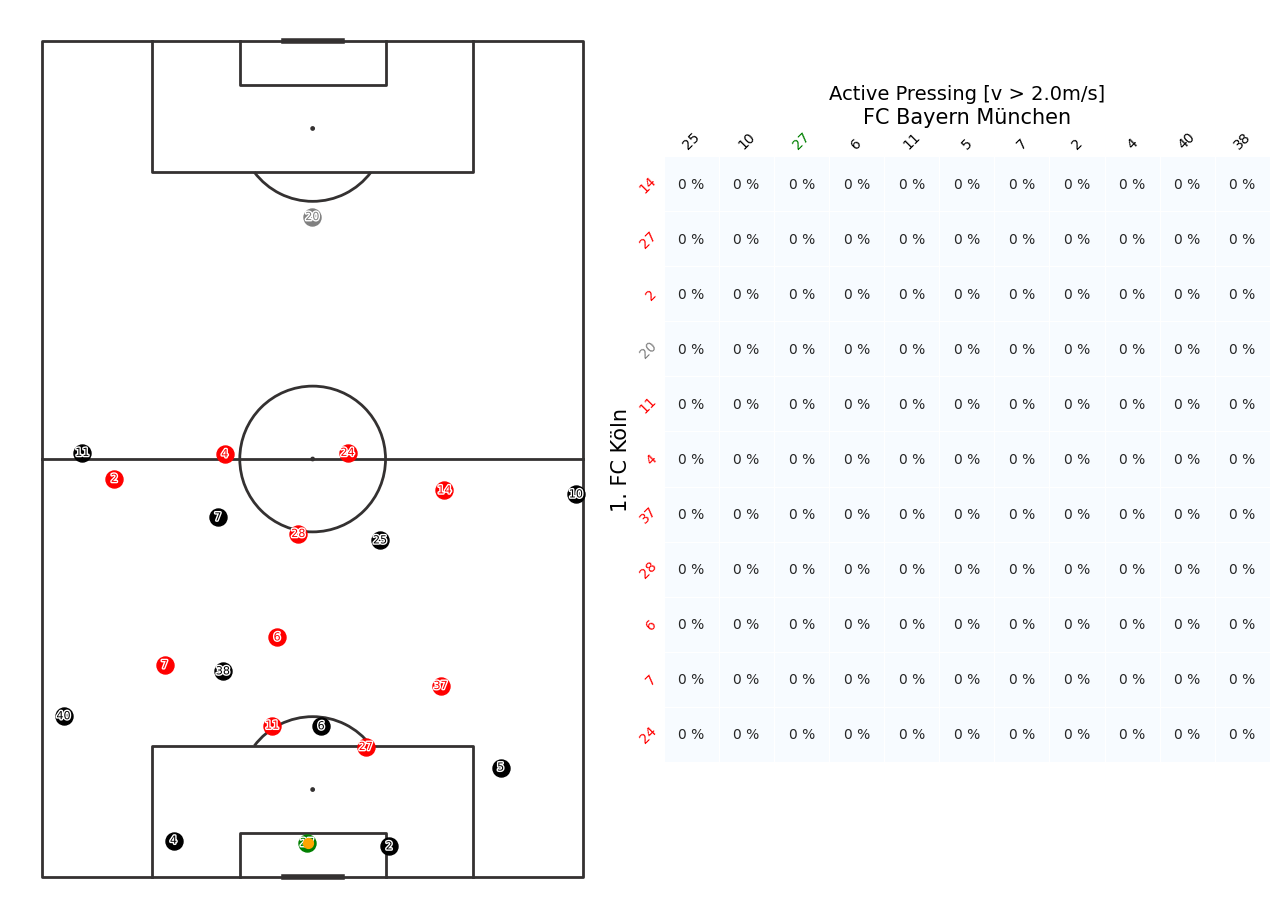

In [8]:
FILE_PATH = "FC Koln v Bayern.mp4"

pitch = VerticalPitch(
    pitch_type=coordinates,
    pitch_length=dataset.settings.pitch_dimensions.pitch_length,
    pitch_width=dataset.settings.pitch_dimensions.pitch_width,
    pitch_color="white",
    line_color="#343131",
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10), gridspec_kw={"wspace": 0.08})
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)


def update(idx):
    ax1.clear()
    ax2.clear()

    pitch.draw(ax=ax1)
    row = model.output.to_pandas().iloc[idx]
    plot_pressing_intensity(row, ax1, ax2)


ani = FuncAnimation(fig, update, frames=len(model.output), repeat=False)
ani.save(
    FILE_PATH, fps=kloppy_dataset.metadata.frame_rate, extra_args=["-vcodec", "libx264"]
)